In [24]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

customers_df = pd.read_csv('data/customers.csv')
products_df = pd.read_csv('data/products.csv')
transactions_df = pd.read_csv('data/transactions.csv')

In [25]:
merged_df = pd.merge(transactions_df, customers_df, on='CustomerID')

# Convert dates
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])

# RFM Features - consider recency, frequency, monetary
latest_date = merged_df['TransactionDate'].max()
rfm = merged_df.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (latest_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',  # Frequency
    'TotalValue': 'sum'  # Monetary
}).rename(columns={
    'TransactionDate': 'recency',
    'TransactionID': 'frequency',
    'TotalValue': 'monetary'
}).reset_index()

# Customer Tenure
tenure = merged_df.groupby('CustomerID').agg({
    'SignupDate': 'first',
    'TransactionDate': 'max'
})
tenure['customer_tenure'] = (tenure['TransactionDate'] - tenure['SignupDate']).dt.days
rfm = rfm.merge(tenure['customer_tenure'], on='CustomerID')

# Behavioral Features
merged_df = merged_df.sort_values(['CustomerID', 'TransactionDate'])
time_diff = merged_df.groupby('CustomerID')['TransactionDate'].diff().dt.days
merged_df['purchase_interval'] = time_diff
behavioral = merged_df.groupby('CustomerID').agg({
    'purchase_interval': ['std', 'mean'],
    'TotalValue': ['std', 'mean']
})
behavioral.columns = ['purchase_consistency', 'purchase_frequency',
                     'value_consistency', 'avg_transaction_value']
rfm = rfm.merge(behavioral, on='CustomerID')

# Region Dummies
region = pd.get_dummies(merged_df.groupby('CustomerID')['Region'].first(), prefix='region')
rfm = rfm.merge(region, on='CustomerID')

# Transaction Velocity
rfm['transaction_velocity'] = rfm['frequency'] / (rfm['customer_tenure']/30 + 1e-6) # incase of 0 - handle edg case 



In [26]:
# Create feature matrix
feature_df = rfm.set_index('CustomerID')
feature_df = feature_df.replace([np.inf, -np.inf], np.nan).fillna(0)


scaler = RobustScaler()
scaled_features = scaler.fit_transform(feature_df)


# Accumulate all the scores
wcss = []
sil_scores = []
db_scores = []
max_clusters = 8

for k in range(2, max_clusters+1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    wcss.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(scaled_features, labels))
    db_scores.append(davies_bouldin_score(scaled_features, labels))


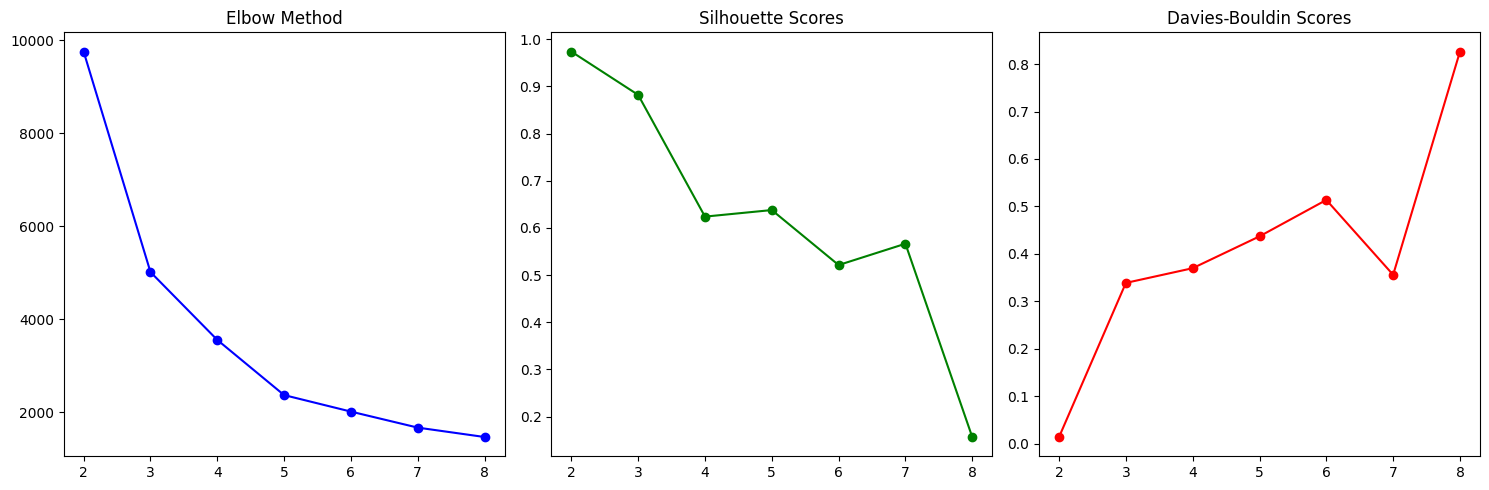

In [27]:
# Plot elbow - give us the optimal number of clusters
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(2, max_clusters+1), wcss, 'bo-')
plt.title('Elbow Method')

# Plot silhouette scores - gives use the separation distance btwn clusters
plt.subplot(1, 3, 2)
plt.plot(range(2, max_clusters+1), sil_scores, 'go-')
plt.title('Silhouette Scores')

# Plot DB scores
plt.subplot(1, 3, 3)
plt.plot(range(2, max_clusters+1), db_scores, 'ro-')
plt.title('Davies-Bouldin Scores')
plt.tight_layout()
plt.show()

Final Davies-Bouldin Score: 0.370


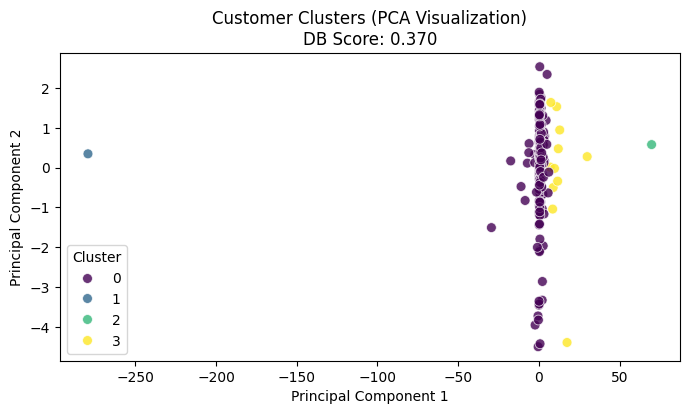

In [28]:
optimal_k = 4 # Optimal clusterd from the above plots
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(scaled_features)

final_db = davies_bouldin_score(scaled_features, cluster_labels)
print(f"Final Davies-Bouldin Score: {final_db:.3f}")

pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 4))
sns.scatterplot(x=principal_components[:, 0], y=principal_components[:, 1],
                hue=cluster_labels, palette='viridis', s=50, alpha=0.8)
plt.title(f'Customer Clusters (PCA Visualization)\nDB Score: {final_db:.3f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [29]:
print(f"Final Davies-Bouldin Score: {final_db:.3f}")
print(f"Number of Clusters: {len(set(cluster_labels))}")


Final Davies-Bouldin Score: 0.370
Number of Clusters: 4
